In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.decomposition import pca_on_xarray
from isca_tools.utils.moist_physics import sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc
from tqdm.notebook import tqdm
from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
from jobs.theory_lapse.isca.load_ds_quant import ds_quant

### Fraction of days used
In the scaling factor computation, we only include days for which the vertical `mod_parcel1` profile is good. We define *good* as having the error less than 25% and having a smaller error than the `const1` method.

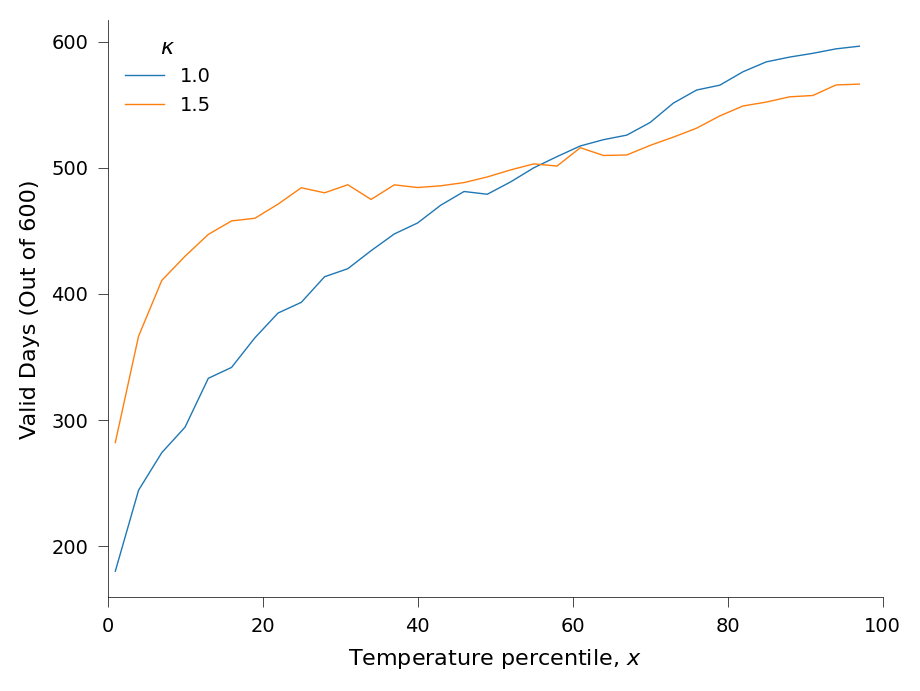

In [4]:
error = {
    key: np.abs(ds_quant[f'{key}1_error'].sum(dim='layer') / ds_quant[f'{key}1_integral'].sum(dim='layer') * 100).isel(
        surf=0)
    for key in ['mod_parcel', 'const']}
mask_use = (error['mod_parcel'] < 25) & (error['mod_parcel'] < error['const'])

lat_weights = np.cos(np.deg2rad(ds_quant.lat))
percentile_label = 'Temperature percentile, $x$'

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    ax.plot(ds_quant.quant, np.average(mask_use.sum(dim='sample').isel(tau_lw=i), axis=1, weights=lat_weights),
            label=f"{mask_use.tau_lw.values[i]:.1f}")
ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
ax.legend(title='$\kappa$')
plt.show()

## Principal Component Analysis
### Initialize data
We initialize data by subtracting the reference values. We obtain reference value for each latitude, and `tau_lw` value. We only use the masked points which have low error for the `mod_parcel1` method to compute the reference values.

In [5]:
ds_pca = ds_quant[['PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']].isel(surf=0)
ds_pca['lapse_mod_D'] = ds_pca.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_pca['lapse_mod_M'] = ds_pca.mod_parcel1_lapse.isel(layer=1) / 1000
ds_pca = ds_pca.drop_vars(['mod_parcel1_lapse'])
ref_method = 'actual'  # Take actual mean values
# ref_method = 'custom'       # Assume follows SQE, and no RH change with warming
if ref_method == 'actual':
    ref_vals = {key: ds_pca[key].where(mask_use).mean(dim=['quant', 'sample']) for key in ds_pca}
else:
    ref_vals = {key: ds_pca[key].where(mask_use).isel(tau_lw=0).mean(dim=['quant', 'sample']) for key in
                ['PREFHT', 'rh_REFHT']}
    ref_vals['lapse_mod_D'] = ref_vals['PREFHT'] * 0
    ref_vals['lapse_mod_M'] = ref_vals['PREFHT'] * 0
ref_vals['TREFHT'] = ds_quant.TREFHT.isel(surf=0).where(mask_use).mean(dim=['quant', 'sample'])
ds_ref = xr.Dataset(ref_vals)

# Compute ref
get_temp_mod_parcel_xr = wrap_with_apply_ufunc(get_temp_mod_parcel)  # make function work with xarray
ds_ref['T_ft_env'] = get_temp_mod_parcel_xr(ref_vals['rh_REFHT'], ref_vals['PREFHT'], ds_quant.p_ft,
                                            ref_vals['lapse_mod_D'],
                                            ref_vals['lapse_mod_M'], ref_vals['TREFHT'],
                                            temp_surf_lcl_calc=ds_quant.temp_surf_lcl_calc)
for key in ds_pca:
    ds_pca[key] = ds_pca[key] - ds_ref[key]

### Correlation between variables
Some variables are correlated as shown below e.g. $T_{FT}$ is larger for smaller $p_s$ and $\eta_D$ is larger for smaller $r_s$.

These correlations indicate the need to do PCA on the raw variables before clustering. The motivation to do clustering can also be seen here, with distinct clusters apparent e.g. there appears to be a dry and moist regime for the highest latitude (yellow), but few points with $r_s\approx 0$.

In the plot below, a separate reference value is removed for each latitude and $\kappa$. Hence a different set of markers for each of these, all centered around zero for each variable. Only masked points are shown, for which the `mod_parcel` fitting is appropriate.

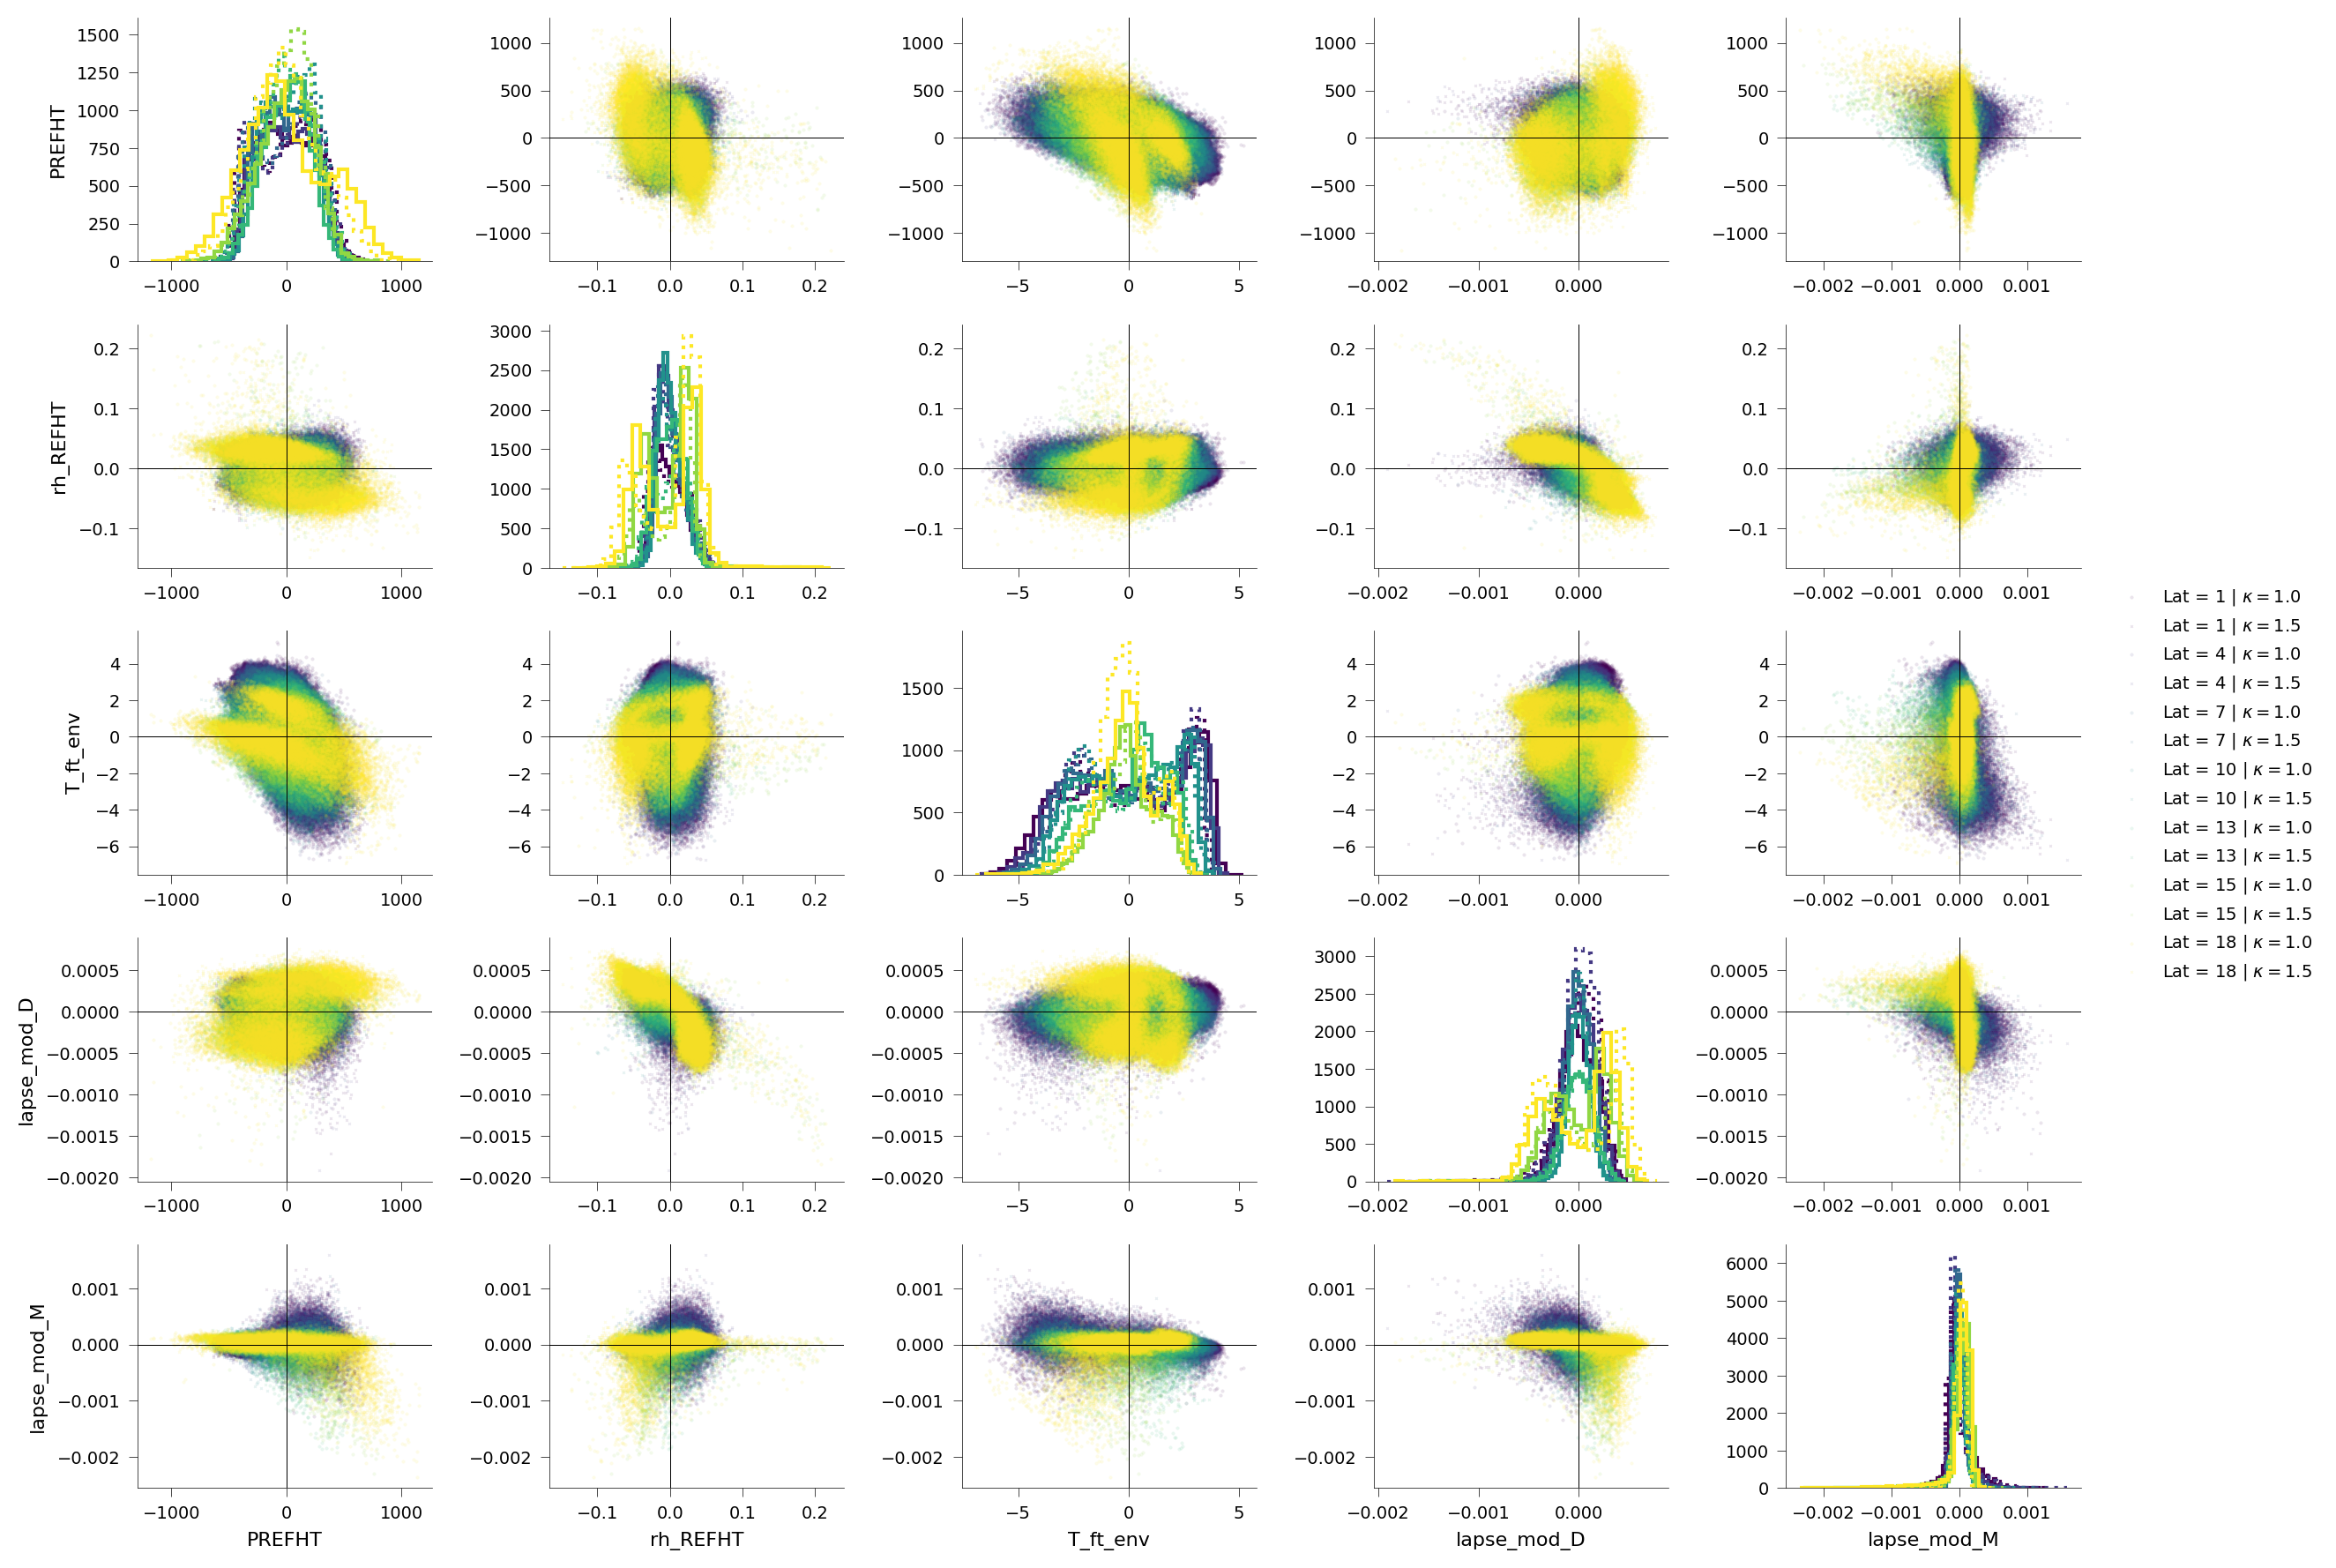

In [6]:
n_var = len(ds_pca.data_vars)
# Unique values for coloring/markers

# Assign colors and markers
colors = plt.cm.viridis(np.linspace(0, 1, len(ds_pca.lat)))
markers = ['.', 'x']  # extend if needed

fig, axes = plt.subplots(n_var, n_var, squeeze=False)
fig_resize(fig, 12)

for i, var_y in enumerate(list(ds_pca.data_vars)):
    for j, var_x in enumerate(list(ds_pca.data_vars)):
        ax = axes[i, j]
        for lat_idx, lat in enumerate(ds_pca.lat):
            for tau_idx, tau in enumerate(ds_pca.tau_lw):
                # Filter data for specific latitude and tau_lw
                x = ds_pca[var_x].where(mask_use).sel(lat=lat, tau_lw=tau)
                y = ds_pca[var_y].where(mask_use).sel(lat=lat, tau_lw=tau)
                if i == j:
                    # Diagonal: histogram line
                    ax.hist(x.values.flatten(), bins=30, color=colors[lat_idx], linestyle=':' if tau_idx == 1 else '-',
                            histtype='step', linewidth=1.5)
                else:
                    ax.scatter(x, y, color=colors[lat_idx], marker=markers[tau_idx],
                               label=f'Lat = {lat:.0f} | $\kappa = {tau:.1f}$', s=1, alpha=0.1)
                    ax.axhline(0, color='k', lw=ax_linewidth)
                    ax.axvline(0, color='k', lw=ax_linewidth)

        if i == n_var - 1:
            ax.set_xlabel(var_x)
        if j == 0:
            ax.set_ylabel(var_y)
        # ax.grid(True)

# Optional: create a single legend
handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center')
plt.tight_layout()
plt.show()

### PC Results
Below I keep the first 3 PCs and plot how surface temperature varies with the PCs, along with the loadings which can be used to understand the surface temperature dependence.

In [7]:
pc_output = pca_on_xarray(xr.concat(list(ds_pca.values()), dim="feature"), n_modes=3, feature_dim_name="feature",
                          valid=mask_use)

In [8]:
def get_temp_surf_from_pc(pc_x_coef, pc_y_coef, pc_eof=pc_output[0], pc_mean=pc_output[2], pc_std=pc_output[3],
                          ds_ref=ds_ref.isel(lat=0, tau_lw=0), pc_x_mode_ind=0, pc_y_mode_ind=2):
    # pc_coef should be n_mode x n_vals
    # pc_eof should be n_mode x n_feature
    # Returns n_pc1_coef x n_pc2_coef
    var = pc_x_coef[:, np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_x_mode_ind).values[np.newaxis, np.newaxis]
    var = var + pc_y_coef[np.newaxis, : np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_y_mode_ind).values[
        np.newaxis, np.newaxis]
    var = var * pc_std.values[np.newaxis, np.newaxis] + pc_mean.values[np.newaxis, np.newaxis]
    # var1 = pc1_coef[:, np.newaxis] * (pc_eof.isel(mode=0) * pc_std).values[np.newaxis]
    # var2 = pc2_coef[:, np.newaxis] * (pc_eof.isel(mode=1) * pc_std).values[np.newaxis]
    # var = var1[:, np.newaxis] + var2[np.newaxis]
    # var = var + pc_mean.values[np.newaxis, np.newaxis]
    p_surf = var[:, :, 0] + float(ds_ref['PREFHT'])
    rh_surf = var[:, :, 1] + float(ds_ref['rh_REFHT'])
    temp_ft_env = var[:, :, 2] + float(ds_ref['T_ft_env'])
    lapse_mod_D = var[:, :, 3] + float(ds_ref['lapse_mod_D'])
    lapse_mod_M = var[:, :, 4] + float(ds_ref['lapse_mod_M'])
    get_temp = np.vectorize(get_temp_mod_parcel)
    return get_temp(rh_surf, p_surf, ds_quant.p_ft, lapse_mod_D, lapse_mod_M, None, temp_ft_env,
                    ds_quant.temp_surf_lcl_calc)

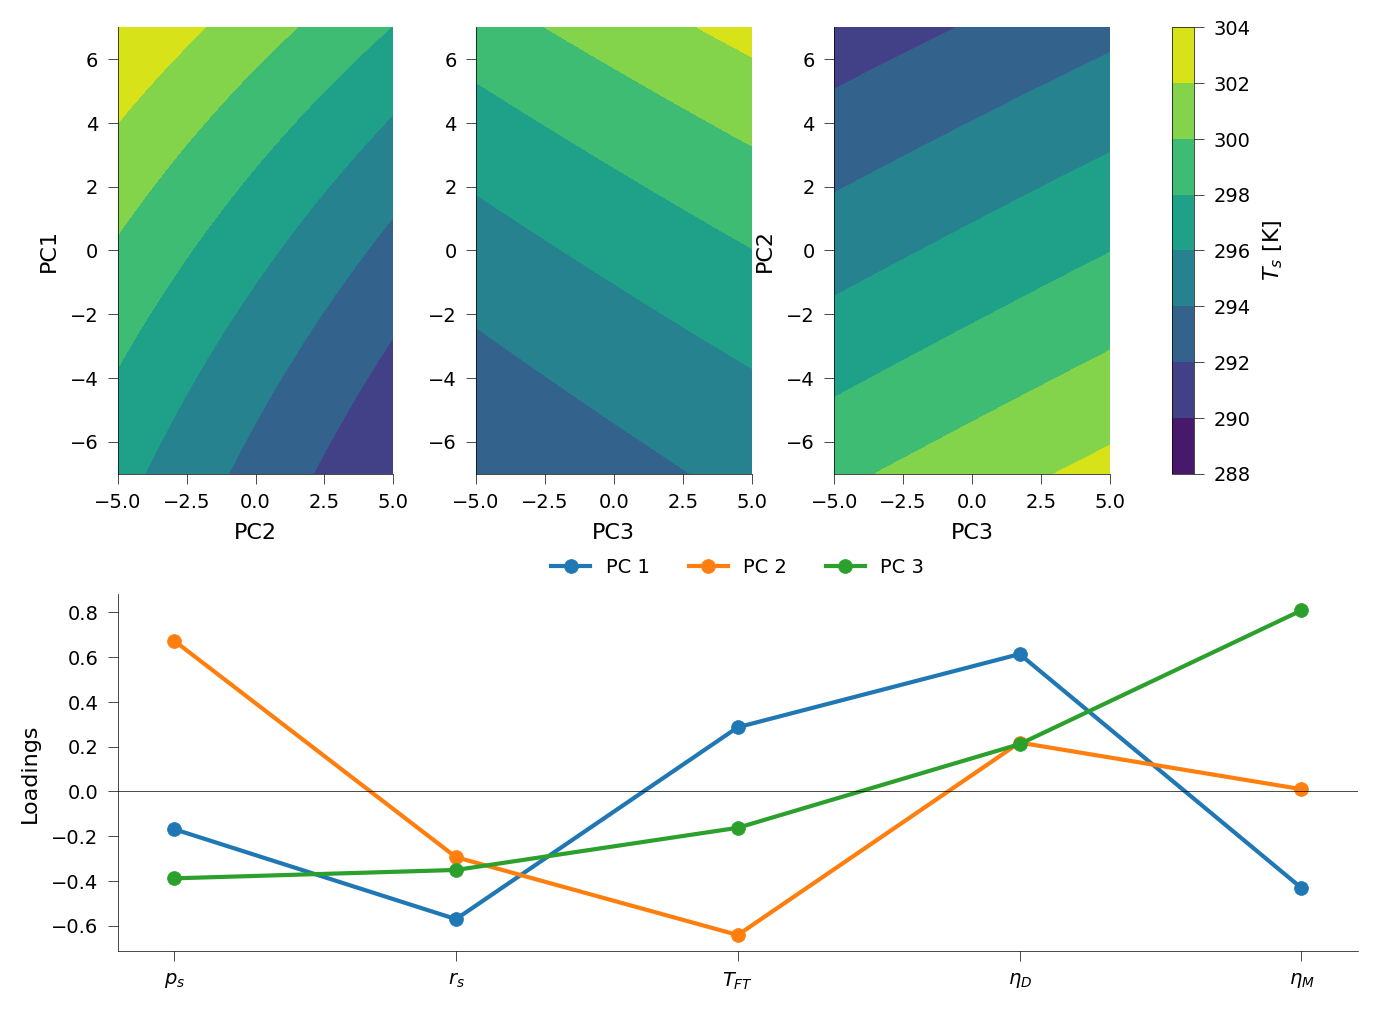

In [9]:
pc_x_coef_plot = np.arange(-5, 5.5, 0.5)
pc_y_coef_plot = np.arange(-7, 7.5, 0.5)

# Generate temperature surfaces
temp_surf_0_1 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=1, pc_y_mode_ind=0)
temp_surf_2_0 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=0)
temp_surf_2_1 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=1)

# Use gridspec to span bottom row
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.8], hspace=0.3, wspace=0.3)

# Top row: contour plots
ax0 = fig.add_subplot(gs[0, 0])
fig_resize(fig, 8)
im0 = ax0.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_0_1.T, levels=np.arange(288, 306, 2))
ax0.set_xlabel('PC2')
ax0.set_ylabel('PC1')

ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_2_0.T, levels=np.arange(288, 306, 2))
ax1.set_xlabel('PC3')

ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_2_1.T, levels=np.arange(288, 306, 2))
ax2.set_xlabel('PC3')
ax2.set_ylabel('PC2')

# Colorbar for top row
plt.colorbar(im2, ax=[ax0, ax1, ax2], label='$T_s$ [K]')

# Bottom row: single axis spanning all columns
ax_line = fig.add_subplot(gs[1, :])
for mode in range(pc_output[0].mode.size):
    ax_line.plot(np.arange(5), pc_output[0].isel(mode=mode), label=f'PC {mode + 1}', color=f"C{mode}", marker='o',
                 lw=1.5, markersize=5)
ax_line.set_xticks(np.arange(pc_output[0].feature.size))
ax_line.set_xticklabels(['$p_s$', '$r_s$', '$T_{FT}$', '$\eta_D$', '$\eta_M$'])
ax_line.set_ylabel('Loadings')
ax_line.legend(ncol=3, bbox_to_anchor=(0.5, 1.00), loc='lower center')
ax_line.axhline(0, color='k', lw=ax_linewidth)
plt.show()


## Can PCs explain the variation in `TREFHT`?
Below we plot to see if the PC latent space is enough to explain the variation in surface temperature at a given latitude.

We compare the `TREFHT` computed from the PC coefficients at each coordinate, to that assuming reference conditions everywhere and
with one or two variables set to their actual value.

We see that the PCs do a worse job that one variable, and two variables is a significant improvement on one variable. So to explain the variation in temperature across quantiles, it seems better to just consider two variables at any coordinate, and set the others to ref values.

In [115]:
ds_quant_sl = ds_quant.isel(lat=-1, surf=0)
# ds_quant_sl = ds_quant.isel(lat=0, surf=0)
# ds_quant_sl['cluster_ind'] = cluster_ind.sel(lat=ds_quant_sl['lat'])
ds_quant_sl['pc_coef'] = pc_output[1].sel(lat=ds_quant_sl['lat'])
for key in ds_pca:
    ds_quant_sl[key] = ds_pca[key].sel(lat=ds_quant_sl['lat'])
for key in ds_ref:
    ds_quant_sl[f"{key}_ref"] = ds_ref[key].sel(lat=ds_quant_sl['lat'])

In [116]:
def get_temp_surf_from_pc_xr(pc_coef, pc_eof, ds_ref, pc_mean=pc_output[2], pc_std=pc_output[3],
                             p_ft=ds_quant_sl.p_ft, temp_surf_lcl_calc=ds_quant.temp_surf_lcl_calc,
                             var_manual=None):
    var = (pc_coef * pc_eof).sum(dim='mode')
    var = var * pc_std + pc_mean

    var_dict = {}
    for i, key in enumerate(['PREFHT', 'rh_REFHT', 'T_ft_env', 'lapse_mod_D', 'lapse_mod_M']):
        var_dict[key] = var.isel(feature=i) + ds_ref[f"{key}_ref"]
    if var_manual:
        for key in var_manual:
            var_dict[key] = var_manual[key]
    return get_temp_mod_parcel_xr(var_dict['rh_REFHT'], var_dict['PREFHT'], p_ft, var_dict['lapse_mod_D'],
                                  var_dict['lapse_mod_M'],
                                  None, var_dict['T_ft_env'], temp_surf_lcl_calc)

In [117]:
TREFHT_recon = {}
var_recon_list = ['PREFHT', 'rh_REFHT', 'T_ft_env', 'lapse_mod_D', 'lapse_mod_M']
with tqdm(total=len(var_recon_list) + 3, position=0, leave=True) as pbar:
    for i in range(3):
        TREFHT_recon[f'PC{i + 1}'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, i)),
                                                              pc_output[0].sel(mode=slice(0, i)), ds_quant_sl)
        pbar.update(1)
    for i, key in enumerate(var_recon_list):
        # TREFHT_recon[key] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)),
        #                                              pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
        #                                              var_manual={key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"]})
        # pbar.update(1)
        TREFHT_recon[key + '_noPC'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)) * 0,
                                                               pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
                                                               var_manual={
                                                                   key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"]})
        pbar.update(1)
TREFHT_recon = xr.Dataset(TREFHT_recon)

  0%|          | 0/8 [00:00<?, ?it/s]

In [118]:
def select_closest_feature(data: xr.DataArray, target: xr.DataArray, min_dim='feature'):
    diff = abs(data - target)
    idx = diff.argmin(dim=min_dim)
    return data.isel(feature=idx), idx


# TREFHT_recon['best'], TREFHT_recon['cluster_idx'] = \
#     select_closest_feature(xr.concat(list(TREFHT_recon[var_recon_list].values()), dim="feature"), ds_quant_sl.TREFHT)

TREFHT_recon['best_noPC'], TREFHT_recon['cluster_idx_noPC'] = \
    select_closest_feature(
        xr.concat(list(TREFHT_recon[[f"{key}_noPC" for key in var_recon_list]].values()), dim="feature"),
        ds_quant_sl.TREFHT)
# Just assume ref values for each day - idea of worst possible approximation
TREFHT_recon['ref'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)).isel(quant=0, sample=0) * 0,
                                               pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl)

# Sanity check that this matches exactly
# TREFHT_recon['exact'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)),
#                                                  pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
#                                                  var_manual={
#                                                      key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"] for key in var_recon_list})

In [119]:
with tqdm(total=len(var_recon_list) ** 2 - len(var_recon_list), position=0, leave=True) as pbar:
    for i, key in enumerate(var_recon_list):
        for j, key2 in enumerate(var_recon_list):
            if i == j:
                continue
            TREFHT_recon[key + '_' + key2 + '_nl'] = get_temp_surf_from_pc_xr(
                ds_quant_sl.pc_coef.sel(mode=slice(0, 0)) * 0,
                pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
                var_manual={
                    key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"],
                    key2: ds_quant_sl[key2] + ds_quant_sl[f"{key2}_ref"]})
            pbar.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [120]:
TREFHT_recon['best_nl'], TREFHT_recon['cluster_idx_nl'] = \
    select_closest_feature(
        xr.concat(list(TREFHT_recon[[key for key in TREFHT_recon if 'nl' in key]].values()), dim="feature"),
        ds_quant_sl.TREFHT)

# If second variable does not help much, then set to single variable method
temp_diff_thresh = 0.3
change_cond = np.abs(TREFHT_recon['best_nl'] - TREFHT_recon['best_noPC']) > temp_diff_thresh
TREFHT_recon['best_nl'] = TREFHT_recon['best_nl'].where(change_cond, TREFHT_recon['best_noPC'])
TREFHT_recon['cluster_idx_nl'] = TREFHT_recon['cluster_idx_nl'].where(change_cond,
                                                                      -TREFHT_recon['cluster_idx_noPC'] - 1)

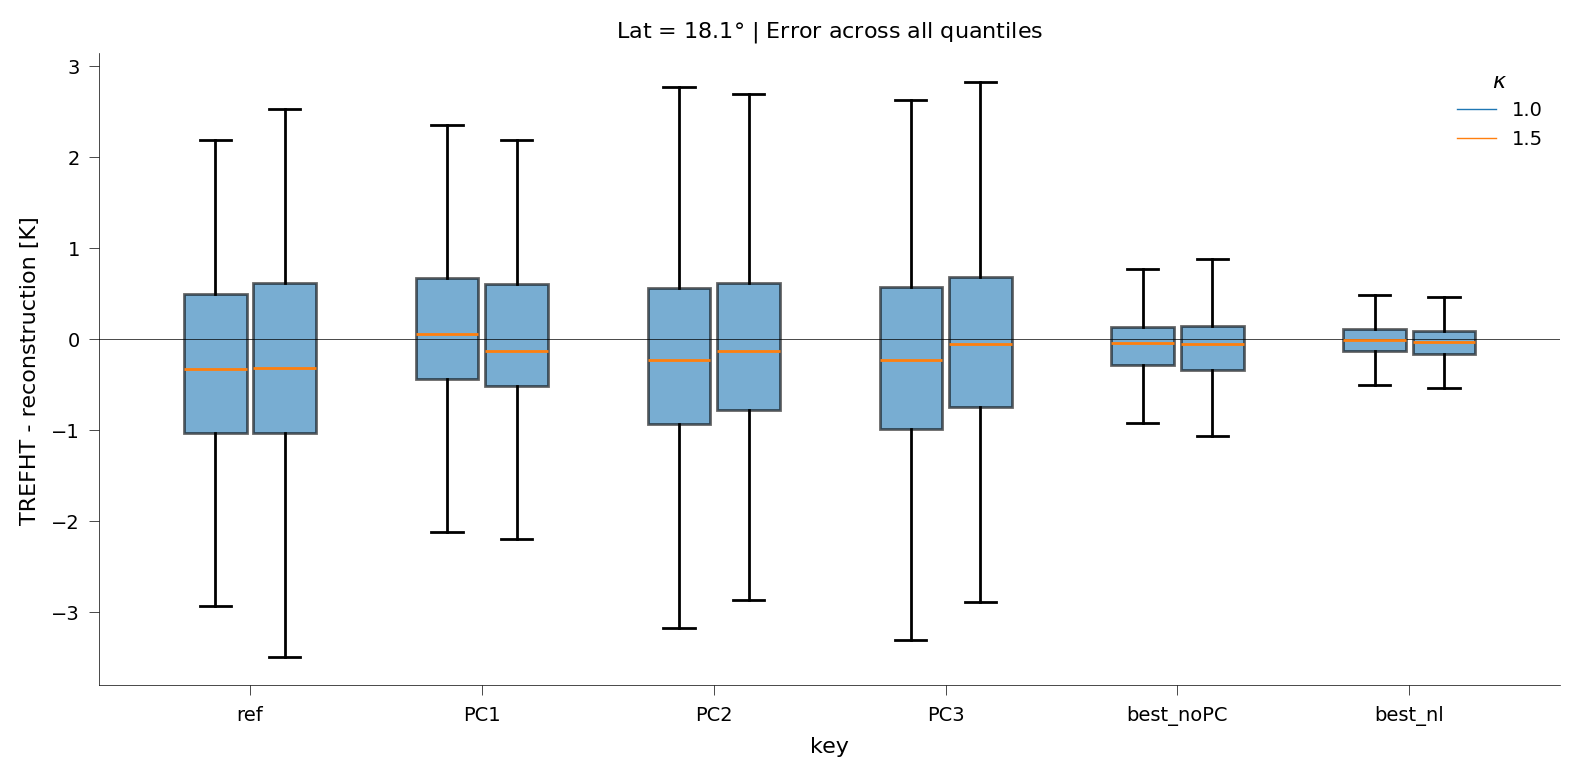

In [121]:
import matplotlib.pyplot as plt
import numpy as np

keys = ['ref', 'PC1', 'PC2', 'PC3', 'best_noPC', 'best_nl']
tau_vals = ds_quant_sl.tau_lw.values
n_keys = len(keys)
n_tau = len(tau_vals)

# Collect data in a 2D list: data[key][tau]
all_data = []
for key in keys:
    key_data = []
    for i in range(n_tau):
        arr = (ds_quant_sl.TREFHT - TREFHT_recon[key]).isel(tau_lw=i).values.flatten()
        key_data.append(arr)
    all_data.append(key_data)

# Plot
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 8, ar=2)
group_width = 0.6
box_width = group_width / n_tau
x_base = np.arange(n_keys)

for j in range(n_tau):
    positions = x_base - group_width / 2 + j * box_width + box_width / 2
    ax.boxplot(
        [all_data[i][j] for i in range(n_keys)],
        positions=positions,
        widths=box_width * 0.9,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(alpha=0.6)
    )

# X labels
ax.set_xticks(x_base)
ax.set_xticklabels(keys)

ax.set_xlabel("key")
ax.set_ylabel("TREFHT - reconstruction [K]")
ax.set_title(f"Lat = {ds_quant_sl.lat:.1f}$\degree$ | Error across all quantiles")

# Legend
legend_labels = [f"{v:.1f}" for v in tau_vals]
for j in range(n_tau):
    ax.plot([], [], label=legend_labels[j])
ax.legend(title="$\kappa$")
ax.axhline(0, color="k", lw=ax_linewidth)

plt.tight_layout()
plt.show()

### `best_nl` Method
If we look at the `best_nl` method is the best method in the above plot, then we see that it over-estimates the temperature of the coldest, and under-estimates the temperature of the hottest days.

We also see the

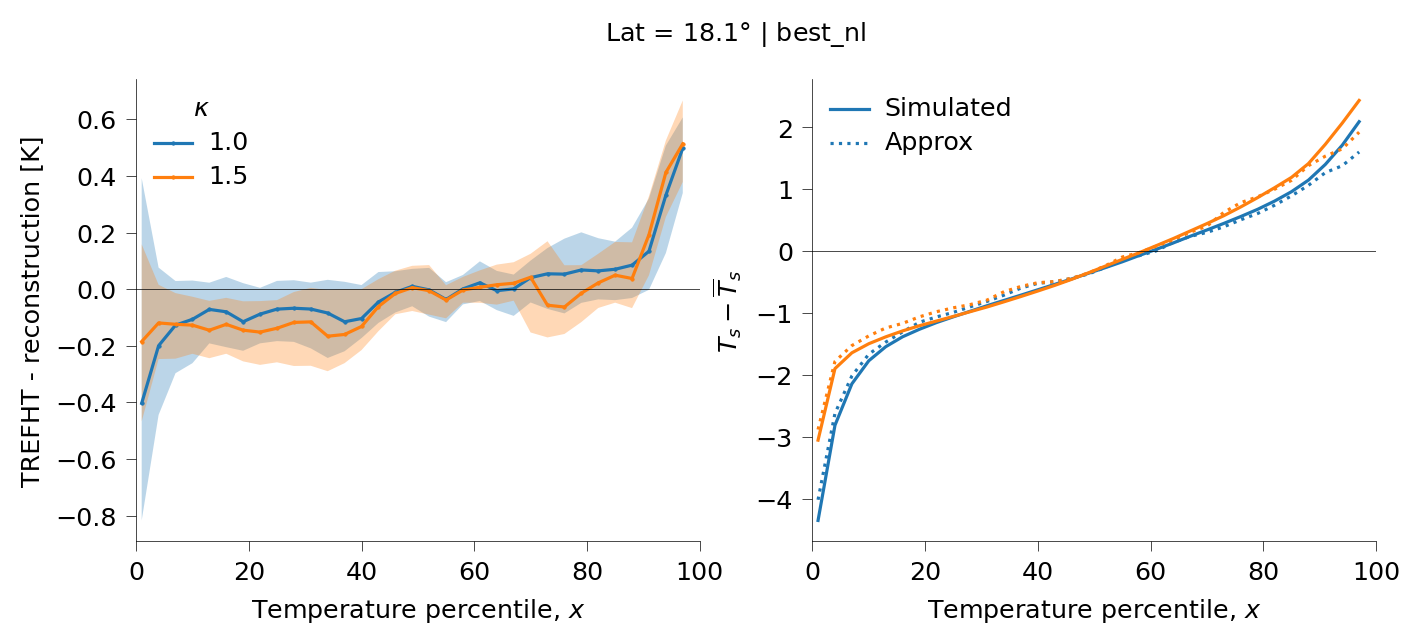

In [122]:
key = 'best_nl'
shift_quant = 0
fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, 8)
for i in range(n_tau):
    var = (ds_quant_sl.TREFHT - TREFHT_recon[key]).isel(tau_lw=i)
    ax[0].plot(ds_quant_sl.quant, var.quantile(0.5, dim='sample'), marker='.', label=f"{ds_quant_sl.tau_lw.values[i]:.1f}")
    ax[0].fill_between(ds_quant_sl.quant, var.quantile(0.25, dim='sample'), var.quantile(0.75, dim='sample'),
                       alpha=0.3)
    ax[1].plot(ds_quant_sl.quant+(i-1)*shift_quant, (ds_quant_sl.TREFHT-ds_quant_sl.TREFHT_ref).quantile(0.5, dim='sample').isel(tau_lw=i),
               label='Simulated' if i==0 else None)
    ax[1].plot(ds_quant_sl.quant+(i-1)*shift_quant, (TREFHT_recon[key]-ds_quant_sl.TREFHT_ref).quantile(0.5, dim='sample').isel(tau_lw=i),
               linestyle=':', color=f"C{i}", label='Approx' if i==0 else None)
ax[0].set_xlim(0, 100)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel("TREFHT - reconstruction [K]")
fig.suptitle(f"Lat = {ds_quant_sl.lat:.1f}$\degree$ | {key}")
if shift_quant != 0:
    ax[1].set_title(f"$\kappa = {ds_quant_sl.tau_lw.values[0]:.1f}$ shifted in $x$ by -{shift_quant}")
update_linewidth(fig)
ax[0].axhline(0, color="k", lw=ax_linewidth)
ax[1].axhline(0, color="k", lw=ax_linewidth)
ax[0].legend(title='$\kappa$')
ax[1].legend()
ax[1].set_ylabel("$T_s - \overline{T}_s$")
update_fontsize(fig)
plt.show()

### Clusters according to important variable
Below, I plot the number of days in a given cluster for each quantile; found using the `best_nl` method. Dotted lines show days for which one variable was sufficient to give a good estimate of `TREFHT`.

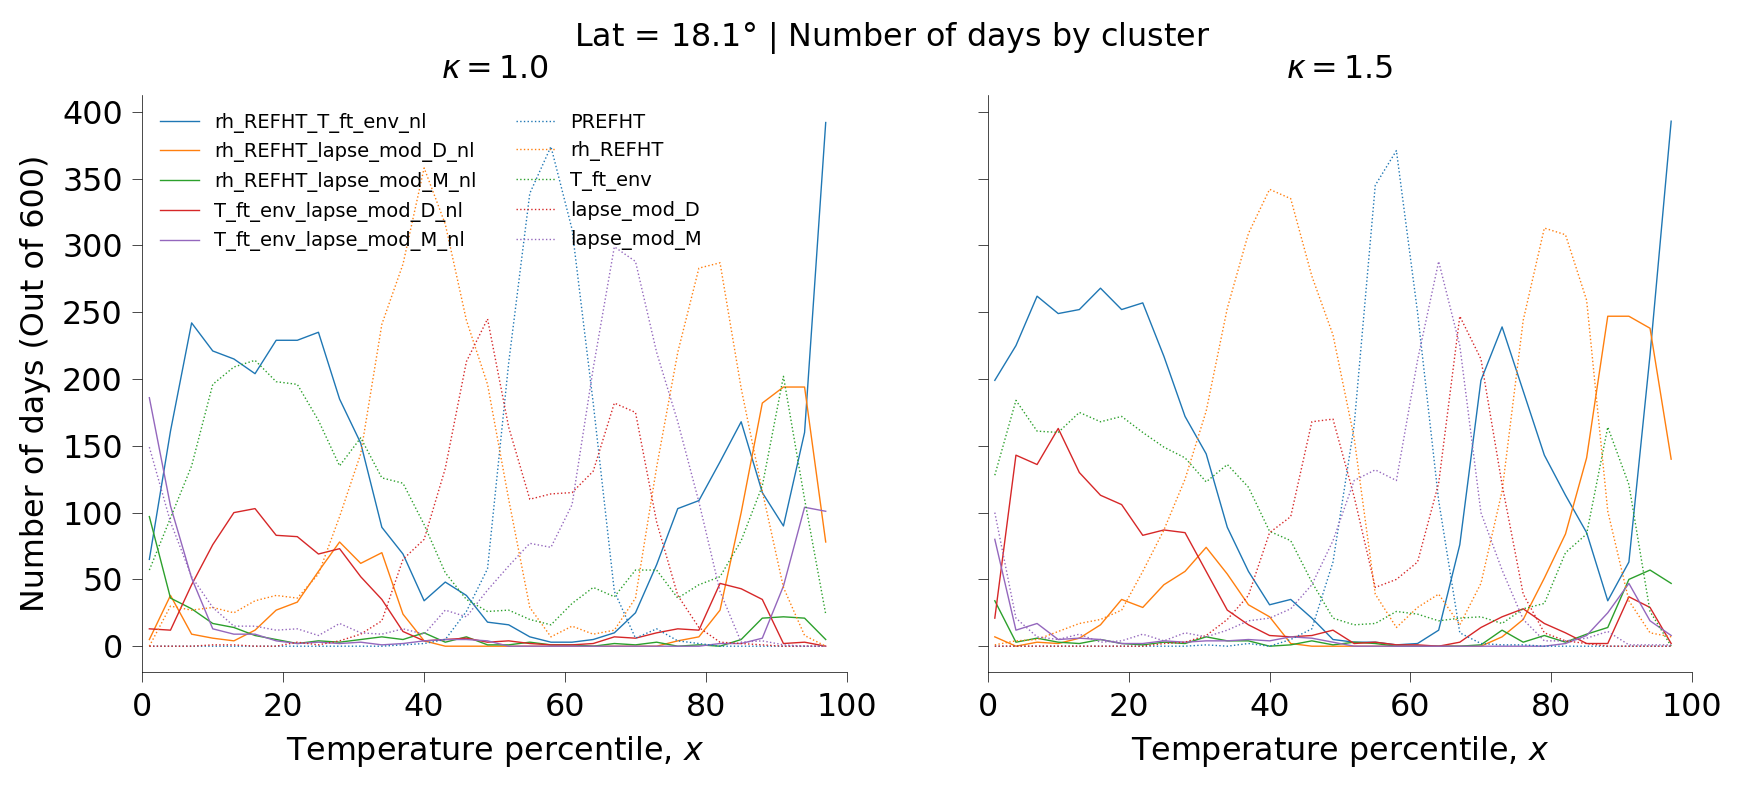

In [123]:
shift_quant = 0
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
fig_resize(fig, 10)
for j in range(n_tau):
    for i, key in enumerate([key for key in TREFHT_recon if 'nl' in key]):
        var = (TREFHT_recon['cluster_idx_nl'] == i).sum(dim='sample')
        if var.max() < 50:
            continue
        ax[j].plot(ds_quant_sl.quant+(j-1)*shift_quant, var.isel(tau_lw=j), label=key)
    for i, key in enumerate(var_recon_list):
        var = (TREFHT_recon['cluster_idx_nl'] == -i - 1).sum(dim='sample')
        if var.max() < 50:
            continue
        ax[j].plot(ds_quant_sl.quant+(j-1)*shift_quant, var.isel(tau_lw=j), label=key, linestyle=':', color=f"C{i}")
    ax[j].set_title(f"$\kappa = {ds_quant_sl.tau_lw.values[j]:.1f}$")
fig.suptitle(f"Lat = {ds_quant_sl.lat:.1f}$\degree$ | Number of days by cluster")
if shift_quant != 0:
    ax[0].set_title(f"$\kappa = {ds_quant_sl.tau_lw.values[0]:.1f}$ | shifted in $x$ by -{shift_quant}")
update_fontsize(fig)
ax[0].legend(ncol=2)
ax[0].set_ylabel(f"Number of days (Out of {ds_quant_sl.sample.size:.0f})")
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
plt.show()

### Non-convective days
Below, I repeat the above plot but only show the `const` or non convective days.

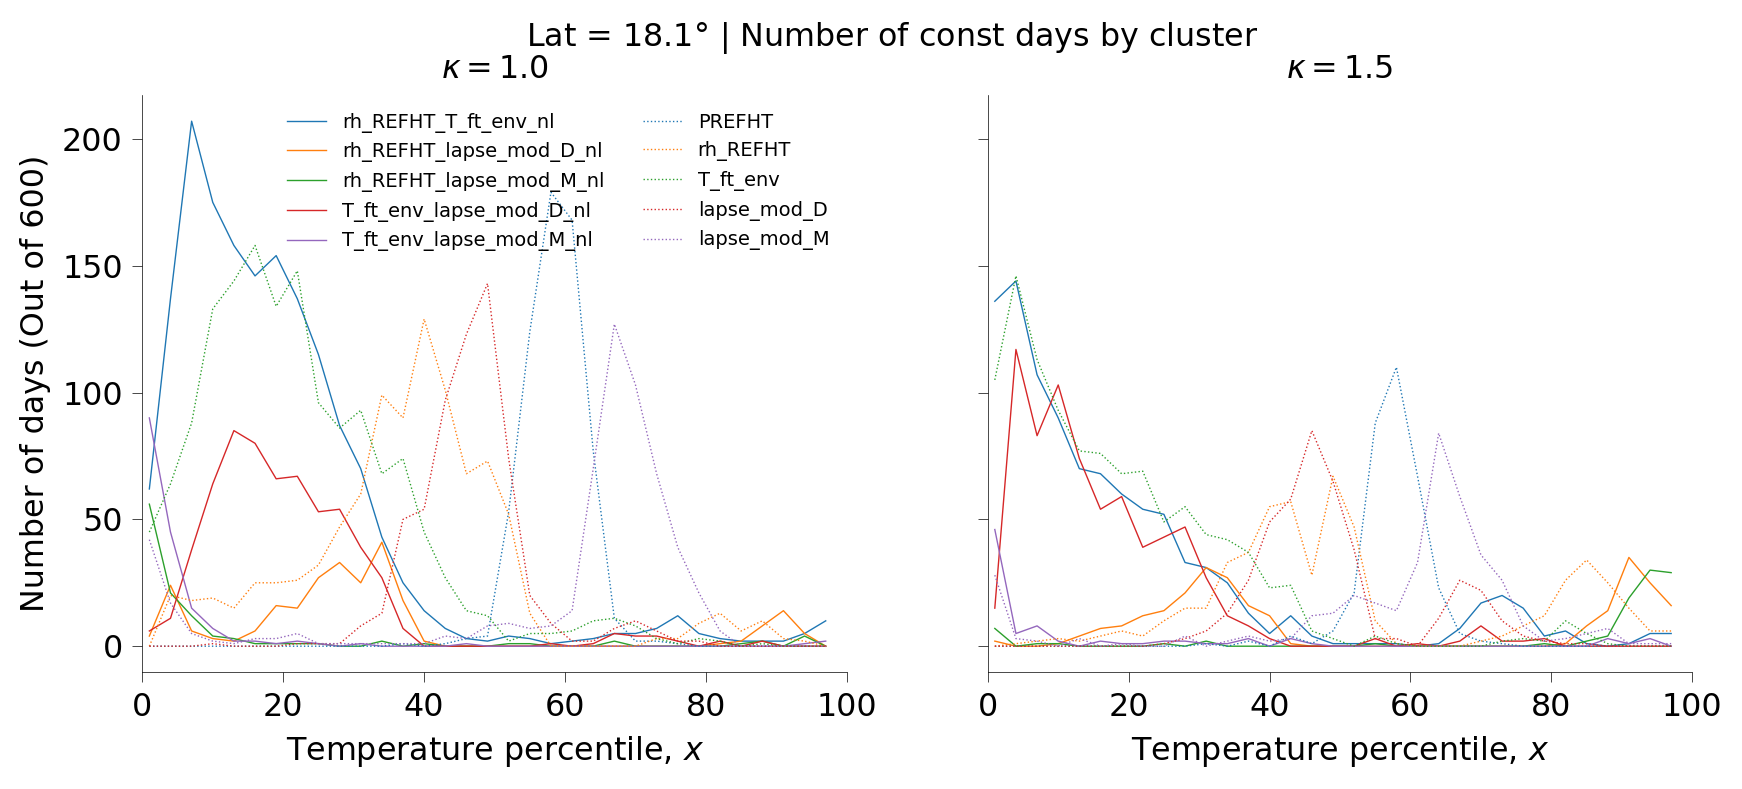

In [126]:
shift_quant = 0
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
fig_resize(fig, 10)
for j in range(n_tau):
    for i, key in enumerate([key for key in TREFHT_recon if 'nl' in key]):
        var = (TREFHT_recon['cluster_idx_nl'] == i).sum(dim='sample')
        if var.max() < 50:
            continue
        var = ((TREFHT_recon['cluster_idx_nl'] == i) & (~mask_use.sel(lat=ds_quant_sl.lat))).sum(dim='sample')
        ax[j].plot(ds_quant_sl.quant+(j-1)*shift_quant, var.isel(tau_lw=j), label=key)
    for i, key in enumerate(var_recon_list):
        var = (TREFHT_recon['cluster_idx_nl'] == -i - 1).sum(dim='sample')
        if var.max() < 50:
            continue
        var = ((TREFHT_recon['cluster_idx_nl'] == -i-1) & (~mask_use.sel(lat=ds_quant_sl.lat))).sum(dim='sample')
        ax[j].plot(ds_quant_sl.quant+(j-1)*shift_quant, var.isel(tau_lw=j), label=key, linestyle=':', color=f"C{i}")
    ax[j].set_title(f"$\kappa = {ds_quant_sl.tau_lw.values[j]:.1f}$")
fig.suptitle(f"Lat = {ds_quant_sl.lat:.1f}$\degree$ | Number of const days by cluster")
if shift_quant != 0:
    ax[0].set_title(f"$\kappa = {ds_quant_sl.tau_lw.values[0]:.1f}$ | shifted in $x$ by -{shift_quant}")
update_fontsize(fig)
ax[0].legend(ncol=2)
ax[0].set_ylabel(f"Number of days (Out of {ds_quant_sl.sample.size:.0f})")
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
plt.show()

### Play around with clusters
Below, I play around a bit with clustering in the PC space.

In [453]:
def cluster_pcs(pcs: xr.DataArray, n_clusters: int, mask: xr.DataArray = None) -> xr.DataArray:
    """Cluster PCA coefficients and return cluster labels for each sample.

    Args:
        pcs: PCA coefficients with dims (quant, tau_lw, lat, sample, mode).
        n_clusters: Number of clusters.

    Returns:
        DataArray of cluster labels with dimension 'sample'.
    """
    pcs_stacked = pcs.stack(point=("quant", "tau_lw", "lat", "sample"))
    if mask is not None:
        mask_stacked = mask.stack(point=("quant", "tau_lw", "lat", "sample"))
        # Select only valid points
        X_train = pcs_stacked.sel(point=mask_stacked).transpose("point", "mode").values
    else:
        X_train = pcs_stacked.transpose("point", "mode").values

    # Fit K-means on masked data only
    km = KMeans(n_clusters=n_clusters, n_init="auto")
    km.fit(X_train)

    X_full = pcs_stacked.transpose("point", "mode").values
    # assign clusters using all features
    labels = km.fit_predict(X_full)
    # unflatten_from_numpy(labels, pcs.isel(mode=0))
    return unflatten_from_numpy(labels, pcs.isel(mode=0))


n_clusters = 3
# cluster_ind = cluster_pcs(pc_output[1], n_clusters, mask_use)
cluster_ind = cluster_pcs(pc_output[1].sel(mode=slice(0, 2)), n_clusters)

In [454]:
ds_quant_sl = ds_quant.isel(lat=-1)
ds_quant_sl['cluster_ind'] = cluster_ind.sel(lat=ds_quant_sl['lat'])
ds_quant_sl['pc_coef'] = pc_output[1].sel(lat=ds_quant_sl['lat'])
for key in ds_pca:
    ds_quant_sl[key] = ds_pca[key].sel(lat=ds_quant_sl['lat'])

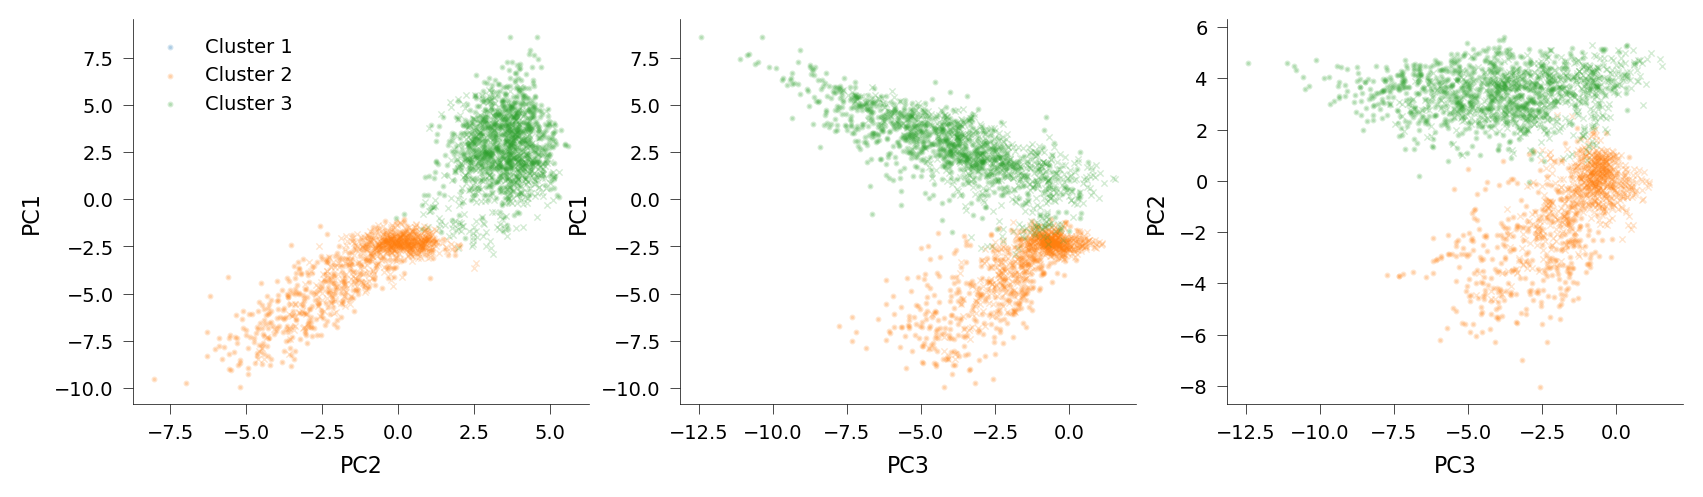

In [455]:
quant_use = slice(-100, 100)
quant_use = slice(0, 4)
# quant_use=slice(95, 100)
fig, ax = plt.subplots(1, 3)
fig_resize(fig, 10)
for i in range(ds_quant_sl.tau_lw.size):
    for j in range(n_clusters):
        mask_plot = ds_quant_sl['cluster_ind'] == j
        ax[0].scatter(ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=1, tau_lw=i).sel(quant=quant_use),
                      ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=0, tau_lw=i).sel(quant=quant_use),
                      marker=['.', 'x'][i], s=5, c=f'C{j}', alpha=0.2, label=f'Cluster {j + 1}' if i == 0 else None)
        ax[1].scatter(ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=2, tau_lw=i).sel(quant=quant_use),
                      ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=0, tau_lw=i).sel(quant=quant_use),
                      marker=['.', 'x'][i], s=5, c=f'C{j}', alpha=0.2)
        ax[2].scatter(ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=2, tau_lw=i).sel(quant=quant_use),
                      ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=1, tau_lw=i).sel(quant=quant_use),
                      marker=['.', 'x'][i], s=5, c=f'C{j}', alpha=0.2)

ax[0].set_ylabel('PC1')
ax[0].set_xlabel('PC2')
ax[1].set_xlabel('PC3')
ax[1].set_ylabel('PC1')
ax[2].set_xlabel('PC3')
ax[2].set_ylabel('PC2')
# ax[0].set_xlim(-10, 10)
# ax[0].set_ylim(-10, 5)
# ax.set_title(f"Lat = {var.lat:.0f}$\degree$")
ax[0].legend()
plt.show()


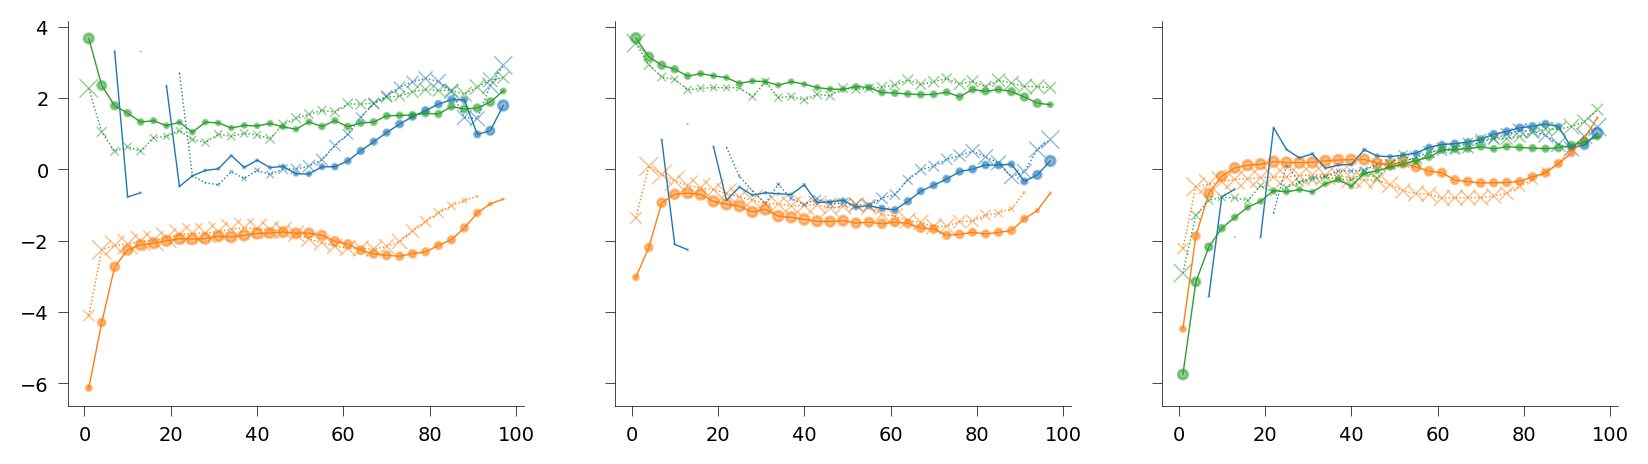

In [477]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)
for j in range(n_clusters):
    mask_plot = ds_quant_sl['cluster_ind'] == j
    n_sample_plot = mask_plot.sum(dim='sample')
    for k in range(ds_quant_sl.mode.size):
        var = ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=k).mean(dim='sample')
        for i in range(ds_quant_sl.tau_lw.size - 0):
            ax[k].plot(ds_quant_sl.quant, var.isel(tau_lw=i), color=f"C{j}",
                       label=f'Cluster {j + 1}' if i == 0 else None,
                       linestyle=[None, ':'][i])
            ax[k].scatter(ds_quant_sl.quant, var.isel(tau_lw=i), s=n_sample_plot.isel(tau_lw=i) / 10, alpha=0.5,
                          color=f"C{j}",
                          marker=['.', 'x'][i])

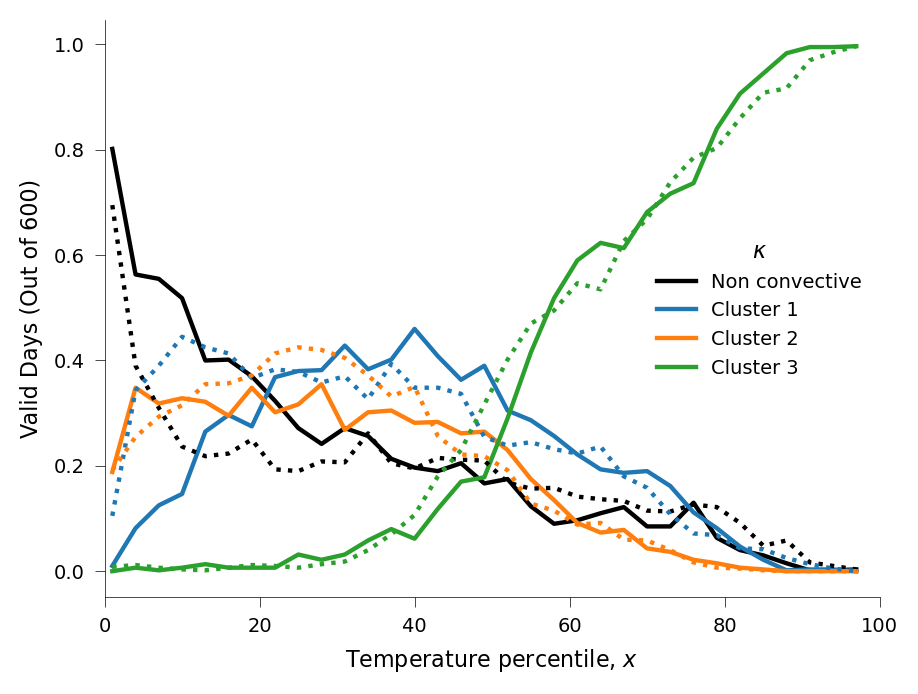

In [399]:
lat_ind_use = slice(0, 1)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    ax.plot(ds_quant.quant, np.average((~mask_use).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use), axis=1,
                                       weights=lat_weights.isel(lat=lat_ind_use)) / ds_quant.sample.size,
            label="Non convective" if i == 0 else None, linestyle=[None, ':'][i], color='k')
    for j in range(n_clusters):
        ax.plot(ds_quant.quant,
                np.average(((cluster_ind == j) & (mask_use)).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use), axis=1,
                           weights=lat_weights.isel(lat=lat_ind_use)) / ds_quant.sample.size,
                linestyle=[None, ':'][i], color=f'C{j}', label=f'Cluster {j + 1}' if i == 0 else None)

ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
update_linewidth(fig)
ax.legend(title='$\kappa$')
plt.show()